In [174]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/My Project Folder/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/My Project Folder/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [176]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-

In [177]:
!pip install --upgrade pyfluidsynth

In [178]:
!pip install pretty_midi

In [179]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [180]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [181]:
data_dir = pathlib.Path('midiler')


In [182]:

filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 194


In [226]:
sample_file = filenames[0]
print(sample_file)

midiler/Ahmet Kaya_Kum Gibi+.mid


In [227]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [185]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [186]:
display_audio(pm)

In [228]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 15
Instrument name: Drawbar Organ


In [188]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=64, note_name=E4, duration=0.0053
1: pitch=60, note_name=C4, duration=0.0053
2: pitch=60, note_name=C4, duration=0.0053
3: pitch=60, note_name=C4, duration=0.0053
4: pitch=60, note_name=C4, duration=0.0053
5: pitch=64, note_name=E4, duration=0.0053
6: pitch=60, note_name=C4, duration=0.0053
7: pitch=60, note_name=C4, duration=0.0053
8: pitch=60, note_name=C4, duration=0.0053
9: pitch=60, note_name=C4, duration=0.0053


In [189]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [190]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,64,4.664887,4.670206,0.000000,0.005319
1,60,4.984036,4.989355,0.319148,0.005319
2,60,5.303184,5.308503,0.319149,0.005319
3,60,5.462758,5.468078,0.159574,0.005319
4,60,5.622333,5.627652,0.159574,0.005319


In [191]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E4', 'C4', 'C4', 'C4', 'C4', 'E4', 'C4', 'C4', 'C4', 'C4'],
      dtype='<U3')

In [192]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [193]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [194]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 12226


In [195]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [196]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [197]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [198]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [199]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5        0.         0.00531914]
 [0.46875    0.3191485  0.00531914]
 [0.46875    0.3191485  0.00531914]
 [0.46875    0.15957425 0.00531914]
 [0.46875    0.15957425 0.00531914]
 [0.5        0.3191485  0.00531914]
 [0.46875    0.3191485  0.00531914]
 [0.46875    0.15957425 0.00531914]
 [0.46875    0.15957425 0.00531914]
 [0.46875    0.3191485  0.00531914]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.15957425000000036>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.005319141666666027>}


In [200]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [201]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [202]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [203]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 128)          67584       ['input_4[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_3[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_3[0][0]']                 
                                                                                            

In [204]:
losses = model.evaluate(train_ds, return_dict=True)
losses

190/190 [==============================] - 10s 25ms/step - loss: 4.8882 - duration_loss: 0.0096 - pitch_loss: 4.8507 - step_loss: 0.0279


{'duration_loss': 0.009600859135389328,
 'loss': 4.888200759887695,
 'pitch_loss': 4.8506927490234375,
 'step_loss': 0.0279100239276886}

In [205]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [206]:
model.evaluate(train_ds, return_dict=True)

190/190 [==============================] - 8s 31ms/step - loss: 0.2800 - duration_loss: 0.0096 - pitch_loss: 4.8507 - step_loss: 0.0279


{'duration_loss': 0.009600859135389328,
 'loss': 0.2800455093383789,
 'pitch_loss': 4.8506927490234375,
 'step_loss': 0.0279100239276886}

In [207]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [208]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
190/190 [==============================] - 15s 54ms/step - loss: 0.2050 - duration_loss: 0.0209 - pitch_loss: 3.3570 - step_loss: 0.0162
Epoch 2/50
190/190 [==============================] - 7s 36ms/step - loss: 0.1359 - duration_loss: 0.0079 - pitch_loss: 2.2825 - step_loss: 0.0139
Epoch 3/50
190/190 [==============================] - 7s 36ms/step - loss: 0.1208 - duration_loss: 0.0062 - pitch_loss: 2.0308 - step_loss: 0.0131
Epoch 4/50
190/190 [==============================] - 9s 47ms/step - loss: 0.1134 - duration_loss: 0.0065 - pitch_loss: 1.8900 - step_loss: 0.0125
Epoch 5/50
190/190 [==============================] - 7s 36ms/step - loss: 0.1081 - duration_loss: 0.0052 - pitch_loss: 1.8013 - step_loss: 0.0128
Epoch 6/50
190/190 [==============================] - 7s 36ms/step - loss: 0.1005 - duration_loss: 0.0051 - pitch_loss: 1.6584 - step_loss: 0.0124
Epoch 7/50
190/190 [==============================] - 7s 36ms/step - loss: 0.0897 - duration_loss: 0.0055 - pitch_los

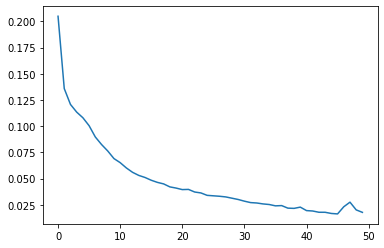

In [209]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [210]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [211]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [212]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,60,0.140634,0.03114,0.140634,0.171774
1,36,0.096160,0.00000,0.236794,0.236794
2,37,0.088932,0.00000,0.325726,0.325726
3,36,0.087845,0.00000,0.413571,0.413571
4,37,0.088047,0.00000,0.501619,0.501619
5,37,0.088305,0.00000,0.589923,0.589923
6,37,0.087990,0.00000,0.677914,0.677914
7,37,0.089427,0.00000,0.767341,0.767341
8,50,0.088902,0.00000,0.856243,0.856243
9,37,0.089325,0.00000,0.945568,0.945568


In [213]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
print('Number of instruments:', len(out_pm.instruments))
instrument = out_pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)
display_audio(out_pm)

Number of instruments: 1
Instrument name: Drawbar Organ
